In [1]:
# !pip show nest_asyncio kaggle > /dev/null || install --upgrade -q nest_asyncio kaggle

In [2]:
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# import asyncio
# import zipfile
# import hashlib
# import nest_asyncio
# import concurrent.futures
# 
# nest_asyncio.apply()
# 
# # List of datasets to download and process
# DATASETS = [
#     ("sartajbhuvaji/brain-tumor-classification-mri", "/content/brain-tumor-classification-mri"),
# ]
# 
# kaggle_dir = os.path.expanduser("~/.kaggle")
# kaggle_json = "kaggle.json"
# 
# # Create the kaggle_dir directory if it doesn't exist
# if not os.path.exists(kaggle_dir):
#     os.makedirs(kaggle_dir)
#     os.rename(kaggle_json, os.path.join(kaggle_dir, kaggle_json))
#     os.chmod(os.path.join(kaggle_dir, kaggle_json), 0o600)
# 
# 
# async def download_dataset(dataset):
#     """
#     Downloads the dataset if it doesn't exist in the given filename.
# 
#     Args:
#         dataset (tuple): Tuple containing the dataset ID and filename.
#     """
#     dataset_id, filename = dataset
#     if not os.path.exists(filename):
#         !kaggle datasets download -d {dataset_id} -p /content
# 
# 
# async def extract_dataset(dataset):
#     """
#     Extracts the dataset if it hasn't been extracted already.
# 
#     Args:
#         dataset (tuple): Tuple containing the dataset ID and filename.
#     """
#     dataset_id, filename = dataset
#     if not os.path.exists(dataset_id):
#         with zipfile.ZipFile(filename, 'r') as zip_ref:
#             zip_ref.extractall('/content')
# 
# async def verify_dataset(dataset):
#     """
#     Verifies the integrity of the downloaded dataset.
# 
#     Args:
#         dataset (tuple): Tuple containing the dataset ID and filename.
#     """
#     dataset_id, filename = dataset
#     if not os.path.exists(dataset_id):
#         expected_hash = dataset_id.split("/")[1]
#         with open(filename, "rb") as file:
#             file_hash = hashlib.md5(file.read()).hexdigest()
#             if file_hash != expected_hash:
#                 print(f"Corrupted file: {filename}")
#         os.remove(filename)
# 
# 
# async def process_dataset(dataset):
#     """
#     Processes a single dataset by downloading, extracting, and verifying it.
# 
#     Args:
#         dataset (tuple): Tuple containing the dataset ID and filename.
#     """
#     await download_dataset(dataset)
#     await extract_dataset(dataset)
#     await verify_dataset(dataset)
# 
# 
# async def main():
#     """
#     Main entry point for the program.
#     Executes the dataset processing tasks concurrently.
#     """
#     tasks = [process_dataset(dataset) for dataset in DATASETS]
#     await asyncio.gather(*tasks)
# 
# 
# asyncio.run(main())

In [4]:
# dataset = Path(r"C:\Users\ashva\Work\Projects\researchAI\Brain Tumor Detection\datasets")
# dataset = Path(r"/content") # colab
dataset = Path(r"/kaggle/input/") # kaggle
# brain_T = dataset / "brain-tumor-classification-mri" # colab
brain_T = dataset / "brain-tumor-classification-mri" # kaggle

In [5]:
def collect_data(dataset_root):
    """
    Collects image data and labels from the dataset directory.

    Args:
        dataset_root (str): Path to the root directory of the dataset.

    Returns:
        list: A list of dictionaries, each containing 'image_path' and 'label' keys.
        list: A list of class names.
    """
    data = []
    class_names = []
    
    # Iterate through each split directory (e.g., "Training" and "Testing")
    for split in os.listdir(dataset_root):
        split_dir = os.path.join(dataset_root, split)
        if not os.path.isdir(split_dir):
            continue
        
        # Iterate through each class subdirectory
        for class_idx, class_name in enumerate(os.listdir(split_dir)):
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            # Add new class name if not already present
            if class_name not in class_names:
                class_names.append(class_name)
            
            # Iterate through images in the class subdirectory
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data.append({"image_path": image_path, "label": class_idx})
    
    return data, class_names

data, class_names = collect_data(brain_T)

In [6]:
# Extract image paths and labels from the data dictionary
image_paths = [entry["image_path"] for entry in data]
labels = [entry["label"] for entry in data]

def format_class_name(class_name):
    """
    Format the class name by capitalizing the first letter of each word.

    Parameters:
        class_name (str): The original class name.

    Returns:
        str: The formatted class name.
    """
    words = class_name.split('_')
    formatted_name = ' '.join([word.capitalize() for word in words])
    return formatted_name

formatted_class_names = [format_class_name(class_name) for class_name in class_names]

In [7]:
def is_black_and_white(image_path, label):
    """
    Process a single image and determine its color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if image.mode == '1' else 'Colored'
    return label, color_type

In [8]:
def count_images_per_class(image_paths, labels, class_names):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        class_names (dict): Dictionary mapping original class names to formatted class names.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    # Process images in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(is_black_and_white, image_paths, labels), total=len(image_paths), desc="Processing images"))

    # Update counts based on processed results
    for label, color_type in processed_results:
        data[class_names[label]][color_type] += 1

    # Create DataFrame from the counts data
    df_data = {'Class': [], 'Black & White': [], 'Colored': []}
    for class_name, counts in data.items():
        df_data['Class'].append(class_name)
        df_data['Black & White'].append(counts['Black & White'])
        df_data['Colored'].append(counts['Colored'])

    df = pd.DataFrame(df_data)
    return df

# Count images per class and display the results
result_df = count_images_per_class(image_paths, labels, formatted_class_names)
print(result_df)

Processing images: 100%|██████████| 3264/3264 [00:02<00:00, 1119.59it/s]

              Class  Black & White  Colored
0          No Tumor              0      500
1   Pituitary Tumor              0      901
2  Meningioma Tumor              0      937
3      Glioma Tumor              0      926


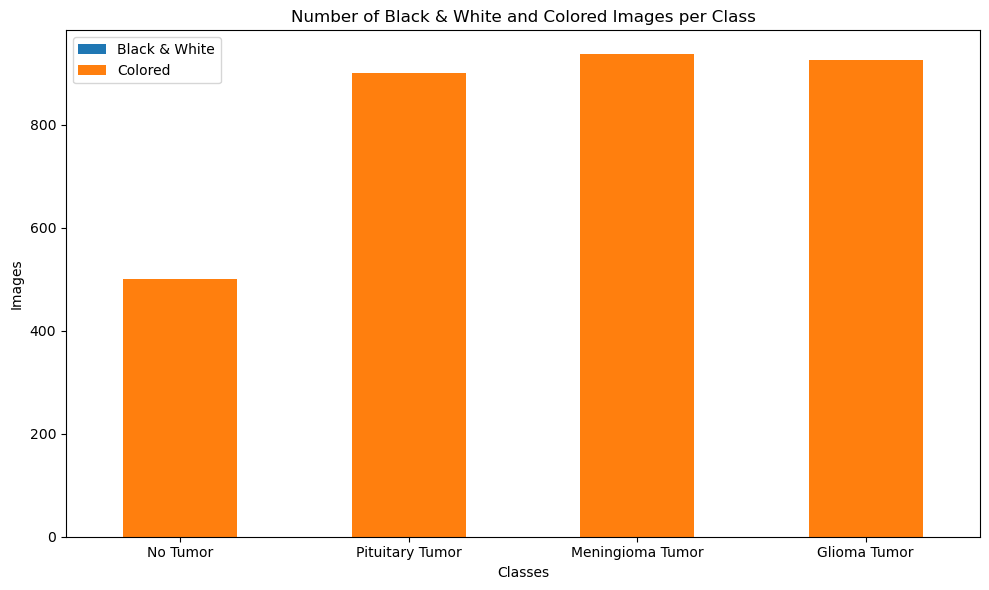

In [9]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    # Set the 'Class' column as the DataFrame index for easy plotting
    result_df.set_index(class_column, inplace=True)

    # Plotting the data
    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 204.59it/s]


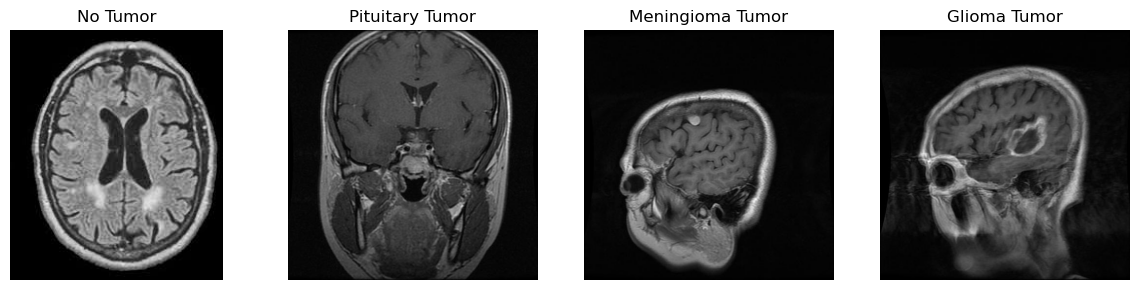

In [10]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels, class_names):
    """
    Display images grouped by class labels.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        class_names (dict): Dictionary mapping original class names to formatted class names.
    """
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    # Calculate the number of rows and columns dynamically
    num_rows = num_classes // 3  # Assuming you want at most 3 columns
    num_cols = min(4, num_classes)  # Maximum 3 columns

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    # Flatten the axs array if num_rows is 1
    if num_rows == 1:
        axs = [axs]

    # Use tqdm to display progress bar
    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            if i >= num_classes:
                break  # In case there are more classes than subplots

            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols][i % num_cols]
                ax.imshow(selected_image, cmap='gray')  # Change cmap if needed
                ax.set_title(class_names[class_label])  # Use the formatted class name
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)  # Update the progress bar

    plt.tight_layout()
    plt.show()

# Display images per class
display_images_per_class(image_paths, labels, formatted_class_names)

In [11]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [12]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.1,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [13]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = formatted_class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 2349
Total Validation Samples: 653
Total Test Samples: 262

Percentage of Split:
Train: 71.97%
Validation: 20.01%
Test: 8.03%

Class Distribution:
                  Train Samples  Validation Samples  Test Samples
No Tumor                    360                 100            40
Pituitary Tumor             649                 180            72
Meningioma Tumor            674                 188            75
Glioma Tumor                666                 185            75


In [14]:
def image_generator(img_paths, img_labels, batch_size):
    """Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_size (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = img_paths[offset:offset + batch_size]
            batch_labels = img_labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(str(img_path))
                resized_image = cv2.resize(image, (64, 64))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [15]:
BATCH_SIZE = 8

train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [16]:
def process_image(image_path, p_s):
    """
    Process an image using layer.

    Args:
        image_path (str): The file path of the input image.
        p_s (tuple): The size of the pooling window (height, width).

    Returns:
        tuple: A tuple containing the original image and the processed image after max pooling,
               negative transformation, and twice max-min pooling.
    """
    # Read the image from the file path
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    # Create instances of layer(s)
    maxpool_layer = layers.MaxPool2D(pool_size=p_s)

    maxpool_image = maxpool_layer(image_tensor)

    # Squeeze the image tensors to remove the batch dimension
    maxpool_image = np.squeeze(maxpool_image.numpy(), axis=0)

    return image, maxpool_image

def visualize_results(cls_n, *img_t_ps):
    """
    Display images along with titles and corresponding class names in a matplotlib plot.

    Args:
        cls_n (str): Class name for the images.
        *img_t_ps: Variable number of image-title pairs as tuples.

    Raises:
        ValueError: If the number of image-title pairs is not 3.

    Returns:
        None
    """
    # Create a 1x3 subplot for displaying the images
    fig, axes = plt.subplots(1, 2)

    for i, (img_t, ax) in enumerate(zip(img_t_ps, axes)):
        img, title = img_t
        if not isinstance(img, np.ndarray):
            raise TypeError(f"Image {i+1} is not a valid numpy array.")
        if len(img.shape) != 3 or img.shape[2] != 3:
            raise ValueError(f"Image {i+1} is not a valid BGR image.")

        # Display the image and set the title
        ax.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

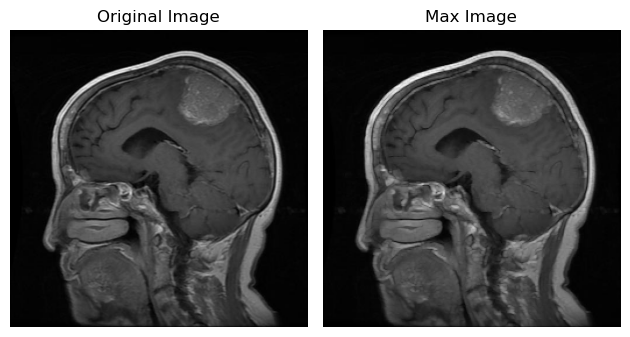

In [17]:
# Choose one random image path and its corresponding label
random_index = random.randint(0, len(image_paths) - 1)
random_image_path = image_paths[random_index]
random_label = labels[random_index]

# Process the random image and create image-title pairs
po_si = (2, 2)

original_image, max_image = process_image(random_image_path, po_si)

# Visualize the results with the class name in the plot title
image_title_pairs = [(original_image, "Original Image"),
                     (max_image, "Max Image")]

visualize_results(random_label, *image_title_pairs)

In [18]:
input_shape = (64, 64, 3)

input_layer = layers.Input(shape=input_shape, name='Input')

conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv1')(input_layer)
max1 = layers.MaxPooling2D(pool_size=(2, 2), name='MaxPool1')(conv1)
conv2 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv2')(max1)
max2 = layers.MaxPooling2D(pool_size=(2, 2), name='MaxPool2')(conv2)

flatten = layers.Flatten(name='Flatten')(max2)

fc1 = layers.Dense(64, name='Dense')(flatten)

output_layer = layers.Dense(num_classes, activation='softmax', name='Output')(fc1)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 62, 62, 32)        896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 31, 31, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 29, 29, 32)        9248      
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 14, 14, 32)        0         
                                                                 
 Flatten (Flatten)           (None, 6272)              0         
                                                                 
 Dense (Dense)               (None, 64)                401472

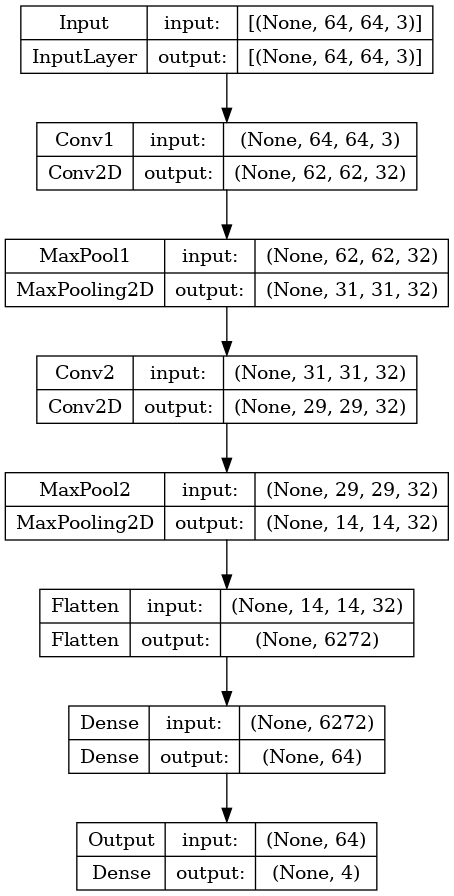

In [19]:
plot_model(model, show_shapes=True)

In [20]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [22]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

# Create an instance of the TimeCallback
time_callback = TimeCallback()

In [23]:
TOTAL_EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[time_callback]
)

Epoch 1/20
293/293 [==============================] - 21s 44ms/step - loss: 0.9902 - accuracy: 0.5900 - precision: 0.6604 - recall: 0.4646 - f1_score: 0.5265 - specificity: 0.9204 - sensitivity: 0.4646 - mcc: 0.4301 - auc: 0.8316 - val_loss: 0.7902 - val_accuracy: 0.6898 - val_precision: 0.7274 - val_recall: 0.6219 - val_f1_score: 0.6661 - val_specificity: 0.9223 - val_sensitivity: 0.6219 - val_mcc: 0.5735 - val_auc: 0.8925
Epoch 2/20
293/293 [==============================] - 15s 51ms/step - loss: 0.5840 - accuracy: 0.7796 - precision: 0.8162 - recall: 0.7283 - f1_score: 0.7661 - specificity: 0.9452 - sensitivity: 0.7279 - mcc: 0.6998 - auc: 0.9413 - val_loss: 0.6463 - val_accuracy: 0.7670 - val_precision: 0.8081 - val_recall: 0.7346 - val_f1_score: 0.7675 - val_specificity: 0.9419 - val_sensitivity: 0.7346 - val_mcc: 0.6992 - val_auc: 0.9305
Epoch 3/20
293/293 [==============================] - 15s 50ms/step - loss: 0.3854 - accuracy: 0.8607 - precision: 0.8808 - recall: 0.8428 - f1_

In [24]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 04 minutes, 43 seconds, 316 milliseconds
Average time per epoch: 14 seconds, 152 milliseconds


In [25]:
_ = model.evaluate(test_generator, steps=test_steps)

32/32 [==============================] - 1s 31ms/step - loss: 0.7629 - accuracy: 0.8906 - precision: 0.8902 - recall: 0.8867 - f1_score: 0.8880 - specificity: 0.9635 - sensitivity: 0.8867 - mcc: 0.8511 - auc: 0.9594


In [26]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

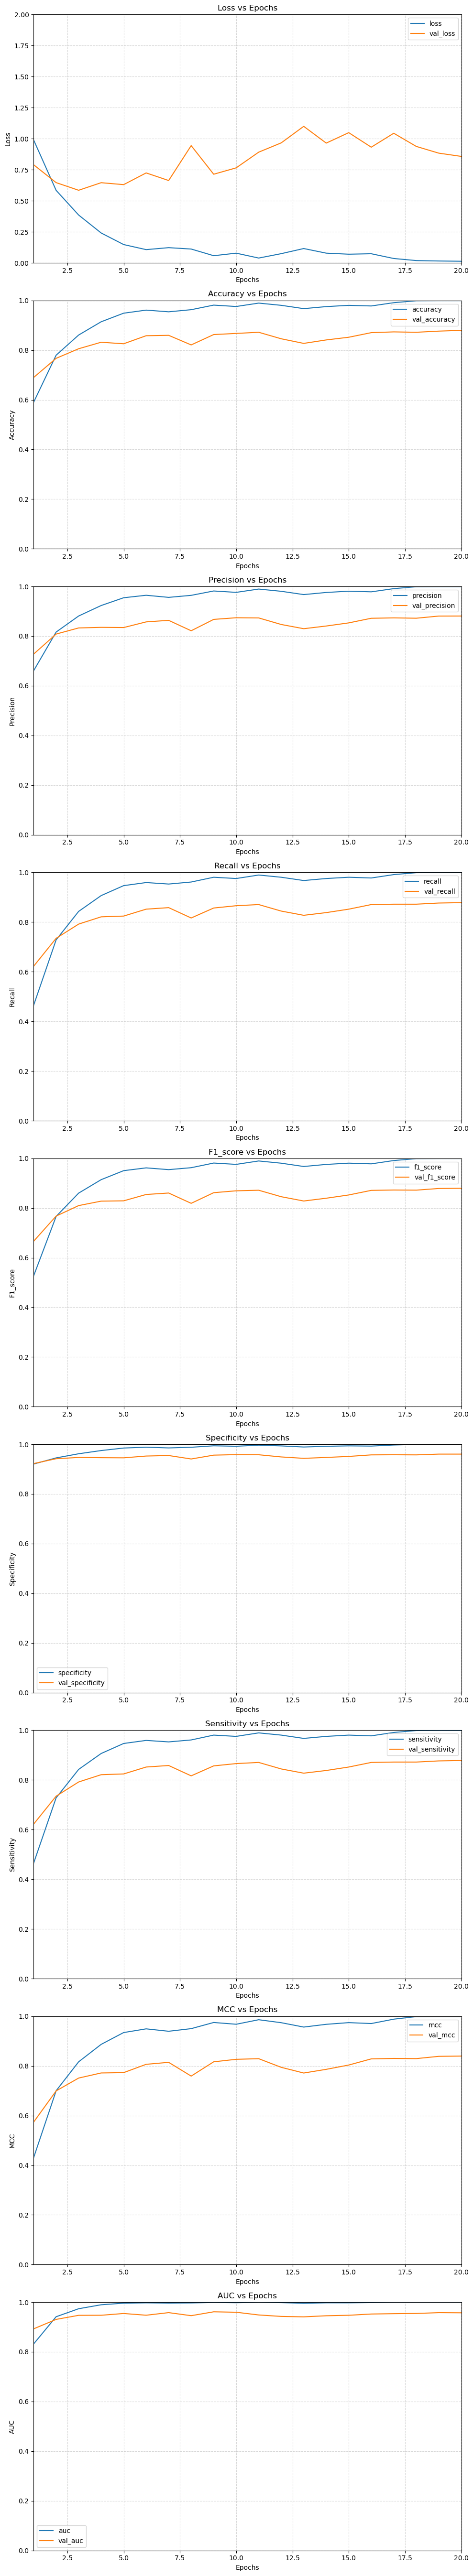

In [27]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [28]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [29]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, formatted_class_names
)

                  precision    recall  f1-score   support

        No Tumor     0.9412    0.8205    0.8767        39
 Pituitary Tumor     0.9324    0.9857    0.9583        70
Meningioma Tumor     0.8205    0.8767    0.8477        73
    Glioma Tumor     0.9000    0.8514    0.8750        74

        accuracy                         0.8906       256
       macro avg     0.8985    0.8836    0.8894       256
    weighted avg     0.8925    0.8906    0.8903       256

There were 28 errors in 256 tests for an accuracy of  89.06


In [30]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

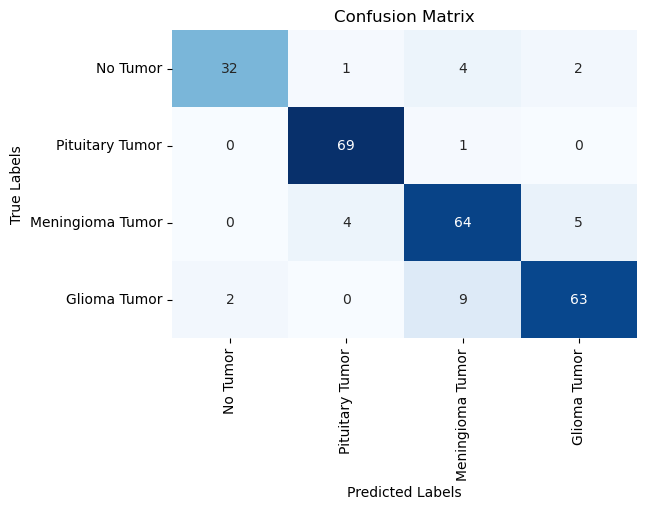

In [31]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=formatted_class_names, yticklabels=formatted_class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()